# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Загрузка библиотек и ознакомление с данными

In [1]:
#conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
import torch
torch.cuda.is_available()

True

In [2]:
#pip install -U crowd-kit lightning sentence-transformers gdown 

In [3]:
import pandas as pd
import numpy as np
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import torch.nn as nn
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from math import ceil
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kkkul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kkkul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kkkul\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kkkul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kkkul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
df_train = pd.read_csv('./train_dataset.csv')
df_train.head(10)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  
5  A young child is wearing blue goggles and sitt...  
6  A young child is wearing blue goggles and sitt...  
7  A young child is wearing blue goggles and sitt...  
8  A young child is wearing blue goggles and sitt...  
9  A young child is wearing blue goggles and sitt...

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [6]:
crowd_columns = ['image', 'query_id', 'score_confirm', 'num_agree', 'num_disagree']
df_crowd = pd.read_csv('./CrowdAnnotations.tsv', sep='\t', names=crowd_columns)
df_crowd.head(10)

image                     query_id  score_confirm  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2       1.000000   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2       0.000000   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2       0.000000   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2       0.000000   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2       0.000000   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2       0.000000   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2       0.000000   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2       0.333333   
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2       0.000000   
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2       0.000000   

   num_agree  num_disagree  
0          3             0  
1          0             3  
2          0             3  
3          0             3  
4          0             3  
5          0             3  
6          0             3  
7          1             2  
8          0             3  
9          0             3

In [7]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image          47830 non-null  object 
 1   query_id       47830 non-null  object 
 2   score_confirm  47830 non-null  float64
 3   num_agree      47830 non-null  int64  
 4   num_disagree   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [8]:
expert_columns = ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3']
df_exp = pd.read_csv('./ExpertAnnotations.tsv', sep='\t', names=expert_columns)
df_exp.head(10)

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2         1         1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2         1         1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2         1         1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2         1         1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2         2         2   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2  
5         1  
6         1  
7         2  
8         1  
9         2

In [9]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [10]:
df_test = pd.read_csv('./test_queries.csv', sep='|')
df_test.head(10)

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   
5           5  1232148178_4f45cc3284.jpg#0   
6           6  1232148178_4f45cc3284.jpg#1   
7           7  1232148178_4f45cc3284.jpg#2   
8           8  1232148178_4f45cc3284.jpg#3   
9           9  1232148178_4f45cc3284.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   
5                    A baby girl playing at a park .   
6  A closeup of a child on a playground with adul...   
7  A young boy poses for a picture in front of a ...   
8  A young girl is smiling in front of the camera...   
9  There is a little blond hair girl with a green...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg  
5  1232148178_4f45cc3284.jpg  
6  1232148178_4f45cc3284.jpg  
7  1232148178_4f45cc3284.jpg  
8  1232148178_4f45cc3284.jpg  
9  1232148178_4f45cc3284.jpg

### Исследование с помощью графического анализа

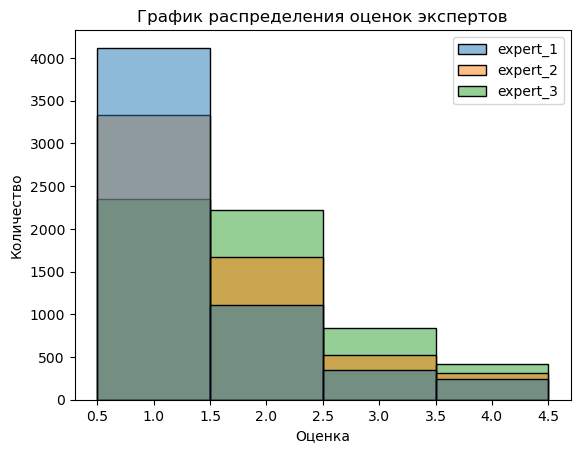

In [11]:
sns.histplot(data=df_exp, bins=4, discrete=True);
plt.title('График распределения оценок экспертов');
plt.xlabel('Оценка');
plt.ylabel('Количество');

Эксперты склонны давать описаниям оценки несоответствия.

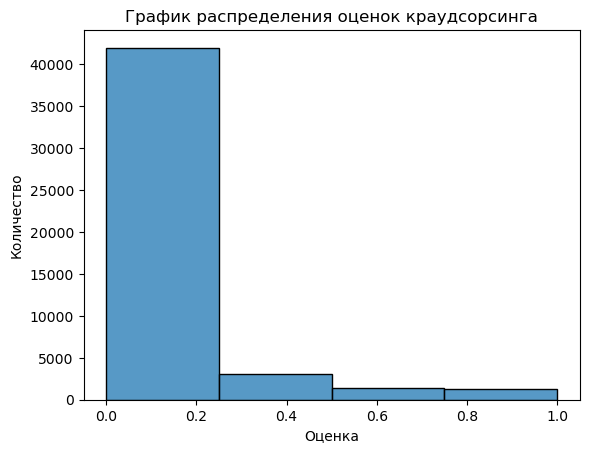

In [12]:
sns.histplot(data=df_crowd, x='score_confirm', bins=4);
plt.title('График распределения оценок краудсорсинга');
plt.xlabel('Оценка');
plt.ylabel('Количество');

Также с оценками каудсорсинга, оценок несоответствия намного больше, чем положительных.

In [13]:
df_exp['mean_score'] = (df_exp['expert_1'] + df_exp['expert_2'] + df_exp['expert_3']) / 3 / 4

In [14]:
df_exp = df_exp.drop(['expert_1', 'expert_2', 'expert_3'], axis=1)

In [15]:
df_exp.head(10)

image                     query_id  mean_score
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2    0.250000
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    0.333333
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2    0.333333
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2    0.416667
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2    0.333333
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2    0.250000
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2    0.250000
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2    0.333333
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2    0.250000
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2    0.500000

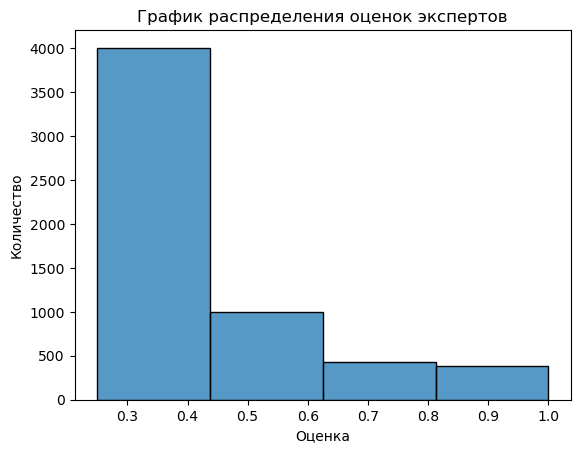

In [16]:
sns.histplot(data=df_exp, x='mean_score', bins=4);
plt.title('График распределения оценок экспертов');
plt.xlabel('Оценка');
plt.ylabel('Количество');

In [17]:
df_train_merged = pd.merge(df_train, df_exp, how='inner', on=['image', 'query_id'])

In [18]:
df_train_merged.head(10)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  mean_score  
0  A young child is wearing blue goggles and sitt...    0.250000  
1  A young child is wearing blue goggles and sitt...    0.250000  
2  A young child is wearing blue goggles and sitt...    0.416667  
3  A young child is wearing blue goggles and sitt...    1.000000  
4  A young child is wearing blue goggles and sitt...    0.250000  
5  A young child is wearing blue goggles and sitt...    0.583333  
6  A young child is wearing blue goggles and sitt...    0.250000  
7  A young child is wearing blue goggles and sitt...    0.250000  
8  A young child is wearing blue goggles and sitt...    0.250000  
9  A young child is wearing blue goggles and sitt...    0.250000

In [19]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   mean_score  5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 227.4+ KB


## 2. Проверка данных

In [20]:
#напишем функцию разметки слов для более качественной лемматизации
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [21]:
#напишем функцию лемматизации
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = nltk.word_tokenize(text)
    lemm_text = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])
        
    return lemm_text

In [22]:
#напишем функцию очистки текста от лишних символов и перевода в один регистр
def clear_text(text):
    return ' '.join(re.sub(r"[^a-zA-Z' ]", ' ', text).split()).lower()

In [23]:
df_train_merged['query_text_lem'] = df_train_merged['query_text'].progress_apply(lemmatize)

  0%|          | 0/5822 [00:00<?, ?it/s]

In [24]:
df_train_merged['query_text_lem'] = df_train_merged['query_text_lem'].apply(clear_text)

In [25]:
stop_words = ['child', 'children', 'baby', 'toddler', 'teenager', 'boy', 'girl', 'kid', 'lad']
delete_img = []

for i in range(len(df_train_merged['query_text_lem'])):
    for word in stop_words:
        if word in df_train_merged.loc[i, 'query_text_lem'].split() and df_train_merged.loc[i, 'mean_score'] > 0.4:
            delete_img.append(df_train_merged.loc[i, 'image'])

Были удалены фотография и описания, содержащие неприемлимый контент, с оценками соответствия более 0.4.

In [26]:
df_train_merged = df_train_merged[~df_train_merged['image'].isin(delete_img)]

In [27]:
df_train_merged = df_train_merged.drop(['query_text', 'query_id'], axis=1).reset_index(drop=True)

In [28]:
#удаление фотографий, код закомментен, так как после первого запуска, фотографии уже удалены
#path = './train_images/'
#for img in set(delete_img):
#    os.remove(path + img)

In [29]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           3678 non-null   object 
 1   mean_score      3678 non-null   float64
 2   query_text_lem  3678 non-null   object 
dtypes: float64(1), object(2)
memory usage: 86.3+ KB


In [30]:
df_train_merged.head(10)

image  mean_score  \
0  1056338697_4f7d7ce270.jpg    0.250000   
1  3155451946_c0862c70cb.jpg    0.250000   
2  3222041930_f642f49d28.jpg    0.250000   
3   486712504_36be449055.jpg    0.250000   
4  1056338697_4f7d7ce270.jpg    0.333333   
5  2616643090_4f2d2d1a44.jpg    0.250000   
6  2648165716_02e2e74fd6.jpg    0.250000   
7  1056338697_4f7d7ce270.jpg    0.333333   
8   463978865_c87c6ca84c.jpg    0.500000   
9   488590040_35a3e96c89.jpg    0.416667   

                                      query_text_lem  
0  a young child be wear blue goggles and sit in ...  
1  a young child be wear blue goggles and sit in ...  
2  a young child be wear blue goggles and sit in ...  
3  a young child be wear blue goggles and sit in ...  
4      a girl wear a yellow shirt and sunglass smile  
5      a girl wear a yellow shirt and sunglass smile  
6      a girl wear a yellow shirt and sunglass smile  
7       a man sleep under a blanket on a city street  
8       a man sleep under a blanket on a city street  
9       a man sleep under a blanket on a city street

## 3. Векторизация изображений

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)
path = './'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация данных
])

# Загрузка предварительно обученной ResNet-18
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
# заморозка слоев
for param in resnet.parameters():
    param.requires_grad_(False)
# убираем все слои, кроме двух последних
resnet = nn.Sequential(*list(resnet.children())[:-1])
# перевод модели в режим предсказания
resnet.eval()

images_paths = list(df_train_merged['image'])
print('Изображений в папке:',len(set(images_paths)))

# Создание пустого массива для хранения векторов
processed_features = []
# Цикл для обработки каждого batch изображений
for image_path in images_paths:
    image_path = path + 'train_images/' + image_path
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet(image_tensor).flatten().cpu().numpy()
    
    processed_features.append(features)  # Добавление векторов признаков в массив
    
processed_features = pd.DataFrame(processed_features)
processed_features.head()

device: cuda
Изображений в папке: 656


0         1         2         3         4         5         6    \
0  0.693983  3.031819  2.916987  0.951920  0.936226  1.245220  0.826550   
1  0.476787  0.516117  1.505917  0.879465  0.001574  0.585608  0.055786   
2  1.859864  2.073176  1.116257  1.751575  0.208846  1.309824  0.316693   
3  1.810253  2.253124  0.628388  1.860260  0.654312  0.030167  1.013323   
4  0.693983  3.031819  2.916987  0.951920  0.936226  1.245220  0.826550   

        7         8         9    ...       502       503       504       505  \
0  1.108059  0.169696  0.365279  ...  0.444238  0.717753  0.294677  0.728790   
1  0.104646  0.206305  1.083964  ...  0.627553  1.203490  2.934107  0.498592   
2  0.456553  2.370869  0.082151  ...  0.407417  1.213631  1.492942  0.690386   
3  1.381325  1.189101  4.414523  ...  0.260167  0.514834  0.756088  0.509969   
4  1.108059  0.169696  0.365279  ...  0.444238  0.717753  0.294677  0.728790   

        506       507       508       509       510       511  
0  1.153809  0.750845  1.196695  0.085011  1.056859  0.098236  
1  1.248345  1.117930  1.121786  2.810126  1.892204  1.877237  
2  1.285157  0.822073  2.123312  1.957901  1.500283  0.300742  
3  1.216290  0.606870  0.671893  0.518883  1.576427  0.530411  
4  1.153809  0.750845  1.196695  0.085011  1.056859  0.098236  

[5 rows x 512 columns]

In [32]:
processed_features.shape

(3678, 512)

Векторизация изображений была произведена с помощью  ResNet-18.

## 4. Векторизация текстов

In [33]:
stopwords = list(set(nltk_stopwords.words('english')))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(df_train_merged['query_text_lem']).toarray()

In [34]:
tf_idf.shape

(3678, 1146)

Векторизация текстов выполнена с помощью TF_IDF

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [35]:
final_vector = np.concatenate((tf_idf, processed_features), axis=1)
final_vector.shape

(3678, 1658)

In [36]:
df = pd.concat([pd.DataFrame(final_vector), df_train_merged], axis=1).drop('query_text_lem', axis=1).reset_index(drop=True)
df.head(10)

0    1    2    3    4    5    6    7    8    9  ...      1650      1651  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.294677  0.728790   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  2.934107  0.498592   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.492942  0.690386   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.756088  0.509969   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.294677  0.728790   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.441835  2.414597   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.119647  1.455929   
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.294677  0.728790   
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.591402  0.638518   
9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  2.915013  0.837326   

       1652      1653      1654      1655      1656      1657  \
0  1.153809  0.750845  1.196695  0.085011  1.056859  0.098236   
1  1.248345  1.117930  1.121786  2.810126  1.892204  1.877237   
2  1.285157  0.822073  2.123312  1.957901  1.500283  0.300742   
3  1.216290  0.606870  0.671893  0.518883  1.576427  0.530411   
4  1.153809  0.750845  1.196695  0.085011  1.056859  0.098236   
5  4.059577  0.064662  0.058353  1.865937  1.541133  0.623635   
6  2.112422  0.434105  0.554733  0.270078  2.066820  0.935831   
7  1.153809  0.750845  1.196695  0.085011  1.056859  0.098236   
8  0.066458  2.295222  1.183057  0.509245  0.911906  0.558338   
9  1.224714  1.227887  0.172840  0.541723  4.871027  0.707625   

                       image  mean_score  
0  1056338697_4f7d7ce270.jpg    0.250000  
1  3155451946_c0862c70cb.jpg    0.250000  
2  3222041930_f642f49d28.jpg    0.250000  
3   486712504_36be449055.jpg    0.250000  
4  1056338697_4f7d7ce270.jpg    0.333333  
5  2616643090_4f2d2d1a44.jpg    0.250000  
6  2648165716_02e2e74fd6.jpg    0.250000  
7  1056338697_4f7d7ce270.jpg    0.333333  
8   463978865_c87c6ca84c.jpg    0.500000  
9   488590040_35a3e96c89.jpg    0.416667  

[10 rows x 1660 columns]

Для обучения модели векторы текстов и изображений были объединены в один

## 6. Обучение модели предсказания соответствия

### Разделение на обучающую и тестовую выборки

In [37]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=2023)
train_indices, valid_indices = next(gss.split(X=df.drop(columns=['mean_score']), y=df['mean_score'], groups=df['image']))
train_df, valid_df = df.loc[train_indices], df.loc[valid_indices]

In [38]:
X_train = train_df.drop(['mean_score', 'image'], axis=1)
y_train = train_df['mean_score']
X_train.shape

(2949, 1658)

In [39]:
X_train.head()

0     1     2     3     4     5     6     7     8     9     ...      1648  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.444238   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.627553   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.260167   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.444238   
5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  1.017806   

       1649      1650      1651      1652      1653      1654      1655  \
0  0.717753  0.294677  0.728790  1.153809  0.750845  1.196695  0.085011   
1  1.203490  2.934107  0.498592  1.248345  1.117930  1.121786  2.810126   
3  0.514834  0.756088  0.509969  1.216290  0.606870  0.671893  0.518883   
4  0.717753  0.294677  0.728790  1.153809  0.750845  1.196695  0.085011   
5  1.012020  0.441835  2.414597  4.059577  0.064662  0.058353  1.865937   

       1656      1657  
0  1.056859  0.098236  
1  1.892204  1.877237  
3  1.576427  0.530411  
4  1.056859  0.098236  
5  1.541133  0.623635  

[5 rows x 1658 columns]

In [40]:
X_valid = valid_df.drop(['mean_score', 'image'], axis=1)
y_valid = valid_df['mean_score']
X_valid.shape

(729, 1658)

In [41]:
#scaler = RobustScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#убрал скейлер, так как метрика от него не изменяется

Выборки были разделены в соотношении 80/20 с помощью метода GroupShuffleSplit

### Обучение линейной регрессии

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [43]:
y_pred = lr.predict(X_valid)
mean_squared_error(y_valid, y_pred)**0.5

407788986.10056615

Модель линейной регрессии выдает совершенно неадекватные результаты.

### Обучение модели CatBoost

In [44]:
%%time
cb = CatBoostRegressor(random_state=2023, logging_level='Silent', loss_function='RMSE', task_type='GPU')

cb_params = {
    'n_estimators': [2000],
    'depth': [8],
    'grow_policy': ['Depthwise']
}
#произведем подбор гиперпараметров
cb_search = GridSearchCV(cb, cb_params, scoring='neg_root_mean_squared_error', cv=3)

cb_search.fit(X_train, y_train)
print('RMSE on train', cb_search.best_score_ * -1)
print('Best parameters', cb_search.best_params_)

RMSE on train 0.17049292555093817
Best parameters {'depth': 8, 'grow_policy': 'Depthwise', 'n_estimators': 2000}
Wall time: 1min 31s


In [45]:
y_pred = cb_search.predict(X_valid)
mean_squared_error(y_valid, y_pred)**0.5

0.17575457108587128

Метрика RMSE на тестовой выборке составила 0.1756, что является неплохим результатом. После подбора гиперпараметров были оставлены лучшие, для сокращения времени запуска кода.

### Обучение полносвязной нейронной сети

In [46]:
X_train_net = torch.tensor(X_train.values, dtype=torch.float, device=torch.device('cuda'))
X_valid_net = torch.tensor(X_valid.values, dtype=torch.float, device=torch.device('cuda'))
y_train_net = torch.tensor(y_train.values, dtype=torch.float, device=torch.device('cuda'))
y_valid_net = torch.tensor(y_valid.values, dtype=torch.float, device=torch.device('cuda'))

In [47]:
 class Net_2(nn.Module):
    def __init__(self, drop, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net_2, self).__init__()

        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.drop = nn.Dropout(drop)
        
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        
        self.layer4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
        nn.init.kaiming_normal_(self.layer1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.layer1.bias, mean=0.5, std=0.7)
        
        nn.init.kaiming_normal_(self.layer2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.layer2.bias, mean=0.5, std=0.7)
        
        nn.init.kaiming_normal_(self.layer3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.layer3.bias, mean=0.5, std=0.7)
        
        nn.init.kaiming_normal_(self.layer4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.layer4.bias, mean=0.5, std=0.7)
        
    def forward(self, X):
        X = torch.relu(self.layer1(X))
        X = self.drop(X)
        X = torch.relu(self.layer2(X))
        X = torch.relu(self.layer3(X))
        X = self.layer4(X)
        return X

In [48]:
%%time
loss = nn.MSELoss()
num_epochs = 2000
best_result = 10000
dropout = [0.4]
batch_sizes = [20]
n_in_neurons = 1658
n_out_neurons = 1
n_hidden_neurons_1_list = [256]
n_hidden_neurons_2_list = [16]
n_hidden_neurons_3_list = [16]

for n_hidden_neurons_1 in n_hidden_neurons_1_list:
    for n_hidden_neurons_2 in n_hidden_neurons_2_list:
        for n_hidden_neurons_3 in n_hidden_neurons_3_list:
            for drop in dropout:    
                net_opt = Net_2(drop, 
                                n_in_neurons, 
                                n_hidden_neurons_1, 
                                n_hidden_neurons_2, 
                                n_hidden_neurons_3, 
                                n_out_neurons).to(device)
    
                optimizer_2 = torch.optim.Adam(net_opt.parameters(), lr=1e-3)
                for batch_size in batch_sizes:
                    num_batches = ceil(len(X_train_net)/batch_size)
                    for epoch in range(num_epochs):
    
                        order = np.random.permutation(len(X_train_net))
    
                        for batch_idx in range(num_batches):
        
                            start_index = batch_idx * batch_size
        
                            optimizer_2.zero_grad()
        
                            batch_indexes = order[start_index:start_index+batch_size]
        
                            X_batch = X_train_net[batch_indexes]
                            y_batch = y_train_net[batch_indexes]
        
                            preds = net_opt.forward(X_batch).to(device).flatten()
        
                            loss_value = loss(preds, y_batch)
                            loss_value.backward()
        
                            optimizer_2.step()
        
                        if epoch % 100 == 0 or epoch == num_epochs - 1:
                            net_opt.eval()
                            test_preds = net_opt.forward(X_valid_net).to(device)
            
                            rmse = (torch.sqrt((test_preds[:, 0] - y_valid_net)**2).float().mean())
                            print(rmse)
                            if rmse < best_result:
                                best_result = rmse
                                best_size = batch_size
                                best_drop = drop
                                best_n_hidden_neurons_1 = n_hidden_neurons_1
                                best_n_hidden_neurons_2 = n_hidden_neurons_2
                                best_n_hidden_neurons_3 = n_hidden_neurons_3
                    
print(best_result, best_size, best_drop)   
print(best_n_hidden_neurons_1, best_n_hidden_neurons_2, best_n_hidden_neurons_3)

tensor(0.1615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1400, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1384, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1351, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1387, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1363, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1374, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1371, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1369, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1368, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1366, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1390, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1382, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1366, device='cuda:0',

Модель полносвязной нейронной сети с 3-мя скрытыми слоями показала наилучший результат RMSE 0.1363. После подбора параметров и архетиктуры сети были оставлены оптимальные.

## 7. Тестирование модели

### Загрузка тестовых запросов и ознакомление с данными

In [49]:
test_df = pd.read_csv('test_queries.csv', sep='|')
test_df.head(10)

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   
5           5  1232148178_4f45cc3284.jpg#0   
6           6  1232148178_4f45cc3284.jpg#1   
7           7  1232148178_4f45cc3284.jpg#2   
8           8  1232148178_4f45cc3284.jpg#3   
9           9  1232148178_4f45cc3284.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   
5                    A baby girl playing at a park .   
6  A closeup of a child on a playground with adul...   
7  A young boy poses for a picture in front of a ...   
8  A young girl is smiling in front of the camera...   
9  There is a little blond hair girl with a green...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg  
5  1232148178_4f45cc3284.jpg  
6  1232148178_4f45cc3284.jpg  
7  1232148178_4f45cc3284.jpg  
8  1232148178_4f45cc3284.jpg  
9  1232148178_4f45cc3284.jpg

In [50]:
#для тестирования модели оставим только необходимый столбец с запросами
test_df = test_df.drop(['Unnamed: 0', 'query_id', 'image'], axis=1)
test_df.head()

query_text
0  Two blonde boys , one in a camouflage shirt an...
1  Two boys are squirting water guns at each other .
2            Two boys spraying each other with water
3  Two children wearing jeans squirt water at eac...
4  Two young boys are squirting water at each oth...

In [51]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_text  500 non-null    object
dtypes: object(1)
memory usage: 4.0+ KB


### Векторизация тестовых изображений

In [52]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация данных
])

# Загрузка предварительно обученной ResNet-18
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
# заморозка слоев
for param in resnet.parameters():
    param.requires_grad_(False)
# убираем все слои, кроме двух последних
resnet = nn.Sequential(*list(resnet.children())[:-1])
# перевод модели в режим предсказания
resnet.eval()

images_paths = os.listdir(path + 'test_images/')
print('Изображений в папке:',len(images_paths))

# Создание пустого массива для хранения векторов
test_features = []
# Цикл для обработки каждого batch изображений
for image_path in images_paths:
    image_path = path + 'test_images/' + image_path
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet(image_tensor).flatten().cpu().numpy()
    
    test_features.append(features)  # Добавление векторов признаков в массив
    
test_features = pd.DataFrame(test_features)
print(test_features.shape)
test_features.head()

Изображений в папке: 100
(100, 512)


0         1         2         3         4         5         6    \
0  0.443964  2.334485  0.006339  2.394352  0.022514  0.329741  1.683885   
1  0.838446  1.568588  1.886730  2.837505  0.734880  0.470229  0.823981   
2  0.443766  0.826593  1.753989  1.080986  0.542635  0.970871  0.315569   
3  0.335738  0.291324  1.498222  0.186021  0.180830  0.099376  1.703926   
4  0.189787  1.876468  0.825719  0.621148  2.310625  0.565720  0.033543   

        7         8         9    ...       502       503       504       505  \
0  1.900141  0.215907  0.033500  ...  0.141606  0.323036  1.905803  1.066338   
1  1.701099  1.028143  0.060939  ...  2.110208  0.119371  0.799623  1.104447   
2  0.813560  1.350496  1.810294  ...  0.700835  0.281531  2.178856  1.093006   
3  1.509952  0.905085  2.503640  ...  0.335947  0.649705  0.139001  0.785380   
4  0.556441  0.402366  4.919667  ...  0.879860  0.729772  0.114589  0.915989   

        506       507       508       509       510       511  
0  0.000000  2.231436  2.022537  2.292718  0.793586  0.850107  
1  1.747196  0.424487  0.182695  1.534220  1.347149  0.404173  
2  0.865926  1.917955  2.054577  1.667660  1.023103  1.039767  
3  0.806339  0.243199  0.270097  0.894142  0.454314  0.001899  
4  0.860375  1.078615  0.487136  1.073112  0.847127  0.025274  

[5 rows x 512 columns]

### Написание функции для тестирования

In [55]:
def test(queries):
    for i in range(10):
        best_result = 0
        best_match_idx = None
        query = queries.loc[random.randint(0, 499)].apply(lemmatize).apply(clear_text)
        for word in stop_words:
            if word in query[0].split():
                print('This image is unavailable in your country in compliance with local laws.')
        for j in range(test_features.shape[0]):
            tf_idf_test = count_tf_idf.transform(query).toarray().flatten()
            test_vector = np.concatenate((tf_idf_test, test_features.loc[j]))
            test_tensor = torch.tensor(test_vector, dtype=torch.float, device=torch.device('cuda'))
            net_opt.eval()
            test_preds = net_opt.forward(test_tensor).to(device).detach().cpu().numpy()[0]
                    
            if test_preds > best_result:
                best_result = test_preds
                best_match_idx = j
        

        print('Текст запроса:', query[0])
        print('Оценка поставленная моделью:', best_result)
        plt.imshow(plt.imread('test_images/' + images_paths[best_match_idx]))
        plt.show()

### Тестирование

Текст запроса: man with brown coat and sunglass wear a blue wig and ball cap
Оценка поставленная моделью: 0.55883646


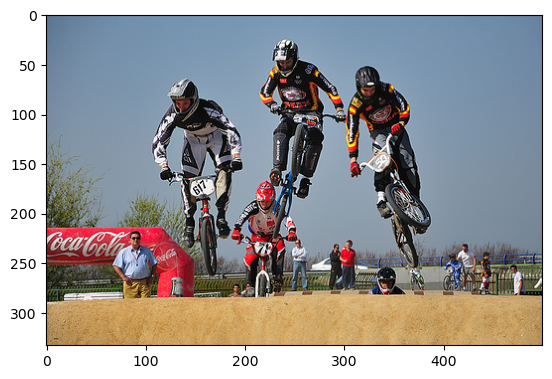

Текст запроса: two woman in head wrap
Оценка поставленная моделью: 0.5857744


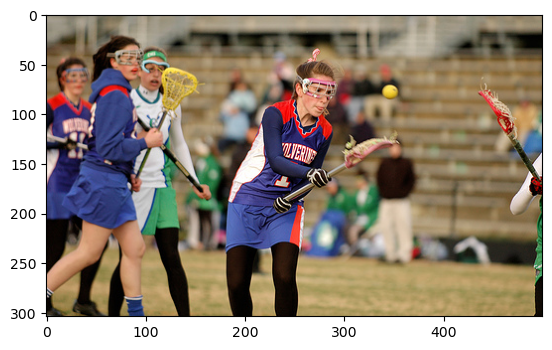

Текст запроса: a dog jumping off a dock into a pool of water
Оценка поставленная моделью: 0.6979922


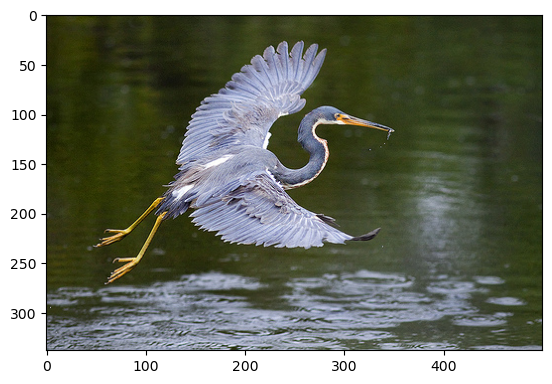

Текст запроса: the brown german shepherd dog be play with a stick
Оценка поставленная моделью: 0.7608801


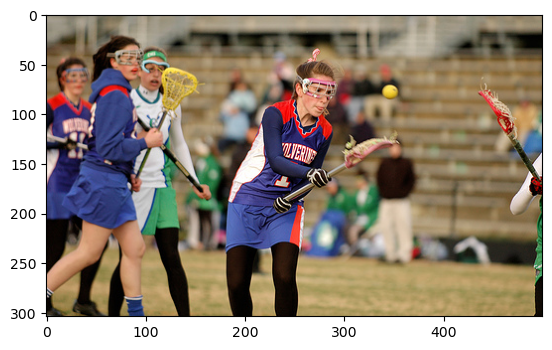

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
Текст запроса: a baby girl play at a park
Оценка поставленная моделью: 0.46243986


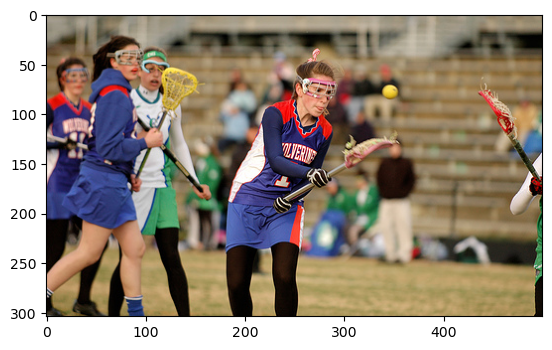

Текст запроса: a man with a black shirt that say genetic freak be sleep on a bus
Оценка поставленная моделью: 0.6110339


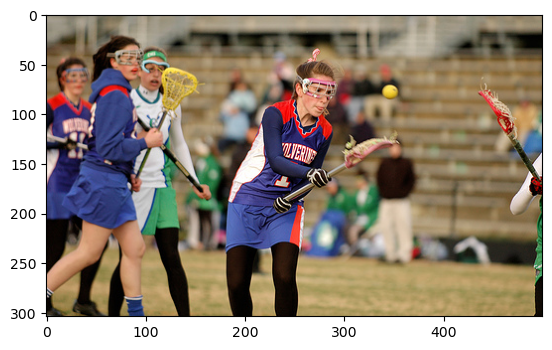

Текст запроса: a man with a white hat and brown shirt behind a woman in red look to the left
Оценка поставленная моделью: 0.6304413


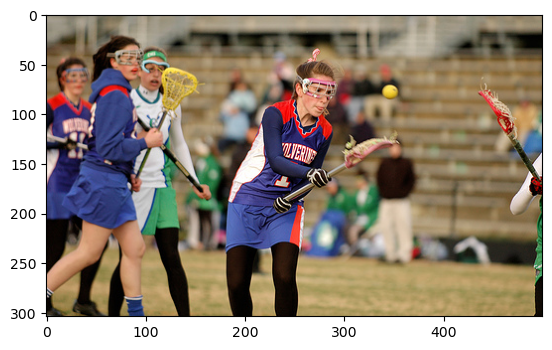

This image is unavailable in your country in compliance with local laws.
Текст запроса: these girl be in uniform and be play field hockey
Оценка поставленная моделью: 0.6537677


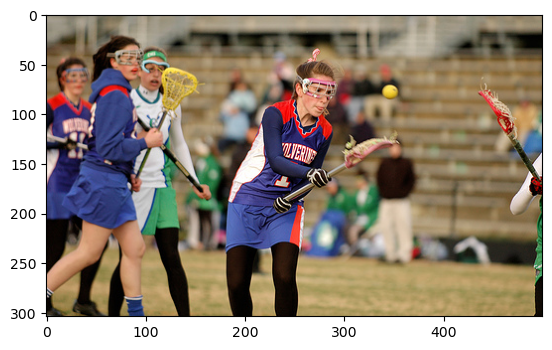

This image is unavailable in your country in compliance with local laws.
Текст запроса: two boy and a white dog stand in a park
Оценка поставленная моделью: 0.42362443


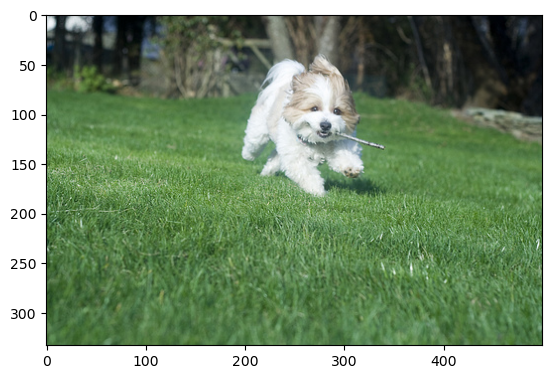

This image is unavailable in your country in compliance with local laws.
Текст запроса: middle school age kid be show their school spirit at a pep ralley
Оценка поставленная моделью: 0.6660193


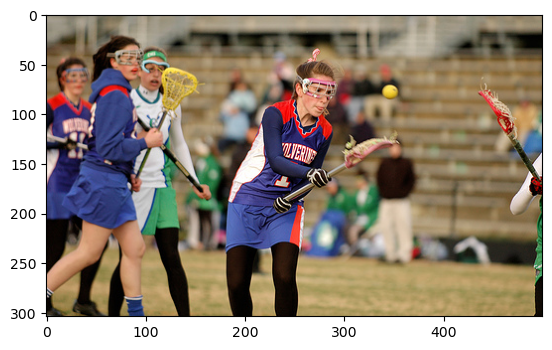

In [56]:
test(test_df)

Перед нами была поставлена задача разработки модели, которая по текстовому запросу выдаст наиболее релевантную фотографию. Для этого в обучающем датасете тесты запросов были лемматизированы, очищены от лишних символов и приведены к одному регистру, а затем были векторизированы с помощью TF-IDF. Для каждого запроса фотографии были векторизированы, а затем конкатенированы с векторами запросов. Целевая переменная была сгенерирована с помощью нормализованных средних оценок от 3-х экспертов. Для обучения были выбраты три модели. Модель LinearRegression показала наихудший результат, с неадекватными прогнозами. Модель CatBoost показала довольно неплохой результат с метрикой RMSE 0.1756. Но лучшей моделью стала полносвязная нейронная сеть с 3-мя скрытыми слоями с RMSE 0.1363. При тестировании модель выдает необходимые результаты. Но у меня не получилось при выдаче дисклеймера не показывать данную фотографию. Также отмечено, что большинству запросов модель ставит наибольшую оценку примерно одним и тем же фотографиям.

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска